# Notebook 1 - building the datasets and doing first level analysis 

- We need to transform the events dataset into a `transfers` dataset. This way we can manipulate easily wether treansfers are ocurring fine. Also in this notebook we will check for the events dataset if might have happened any bug in a given moment of the lifecycle of the product

- Transactions must follow a happy path: Transfer Created -> Transfer Funded -> Transfer Transferred. However, a customer can be willing to retain its funds on their wise account, thus for this evaluation we should look into `settled` and `partially_settled`. Failure can be defined as the inability to reach transfer_funded status. 

## Imports

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
from src.funnel_utils import normalize_events, attach_transfer_keys, build_transfer_level, daily_funnel, global_daily, WISE_COLORS



In [20]:
# Load raw to rewrite dataset
raw = pd.read_csv("../data/wise_funnel_events.csv", parse_dates=["dt"])



In [21]:
#Early Validation
print(raw.shape)
print(raw.info())
raw.head()

(73440, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73440 entries, 0 to 73439
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_name  73440 non-null  object        
 1   dt          73440 non-null  datetime64[ns]
 2   user_id     73440 non-null  float64       
 3   region      73440 non-null  object        
 4   platform    73440 non-null  object        
 5   experience  73440 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 3.4+ MB
None


,event_name,dt,user_id,region,platform,experience
0,Transfer Funded,2024-02-15,1513280.0,NorthAm,iOS,Existing
1,Transfer Funded,2024-02-29,1270052.0,NorthAm,iOS,Existing
2,Transfer Transferred,2024-02-29,1270052.0,NorthAm,iOS,Existing
3,Transfer Funded,2024-02-25,1399835.0,NorthAm,iOS,Existing
4,Transfer Transferred,2024-02-25,1399835.0,NorthAm,iOS,Existing


In [22]:
#This is an events dataset. I need to transform it on a transfer dataset, however I want to check some information prior: Are Ther

In [23]:
# Normalize, attach keys, build transfer-level
df = normalize_events(raw, dt_col="dt")
df = attach_transfer_keys(df, dt_col="dt")
transfers = build_transfer_level(df, dt_col="dt")

# Save base datasets
transfers.to_csv("../data/transfers_level.csv", index=False)

# Daily segmented + Global
daily = daily_funnel(transfers)
global_d = global_daily(daily)
daily.to_csv("../data/daily_segmented.csv", index=False)
global_d.to_csv("../data/daily_global.csv", index=False)

print("Datasets written.")

/Users/leonardomachado/dev/wise_case_study/notebooks/../src/funnel_utils.py:40: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  first_times = df.pivot_table(index="transfer_key", columns="stage", values=dt_col, aggfunc="min")\
/Users/leonardomachado/dev/wise_case_study/notebooks/../src/funnel_utils.py:44: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  flags = df.pivot_table(index="transfer_key", columns="stage", values=dt_col, aggfunc="count")\


Datasets written.


In [24]:

# Validation snapshot + sanity checks
summary = {
    "total_transfers": len(transfers),
    "created_only": int(((transfers.transfer_created) & ~(transfers.transfer_funded | transfers.transfer_transferred)).sum()),
    "created_and_funded": int(((transfers.transfer_created) & (transfers.transfer_funded) & ~transfers.transfer_transferred).sum()),
    "fully_settled": int(((transfers.transfer_created) & (transfers.transfer_funded) & (transfers.transfer_transferred)).sum()),
}
summary


{'total_transfers': 43070,
 'created_only': 23784,
 'created_and_funded': 8208,
 'fully_settled': 11078}

In [25]:
#unique counts and consistency checks
n_users = transfers["user_id"].nunique()
by_region = transfers.groupby("region").size().sort_values(ascending=False)
by_platform = transfers.groupby("platform").size().sort_values(ascending=False) if "platform" in transfers else pd.Series(dtype=int)
by_experience = transfers.groupby("experience").size().sort_values(ascending=False) if "experience" in transfers else pd.Series(dtype=int)

n_users, by_region.head(10), by_platform.head(10), by_experience.head(10)


(40223,
 region
 Other      16451
 Europe     16308
 NorthAm    10311
 dtype: int64,
 platform
 Android    16756
 iOS        13954
 Web        12360
 dtype: int64,
 experience
 New         26056
 Existing    17014
 dtype: int64)

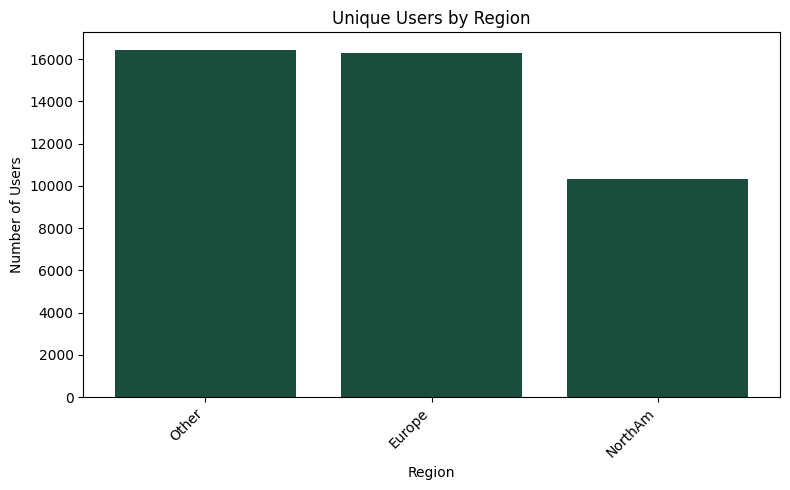

In [26]:
#Unique Per Region
plt.figure(figsize=(8, 5))
plt.bar(
    by_region.index.astype(str),
    by_region.values,
    color=WISE_COLORS[0]
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Number of Users")
plt.title("Unique Users by Region")
plt.tight_layout()
plt.show()

#It's odd to observe that a Product MXN -> USD is atracting more people from Outside North America

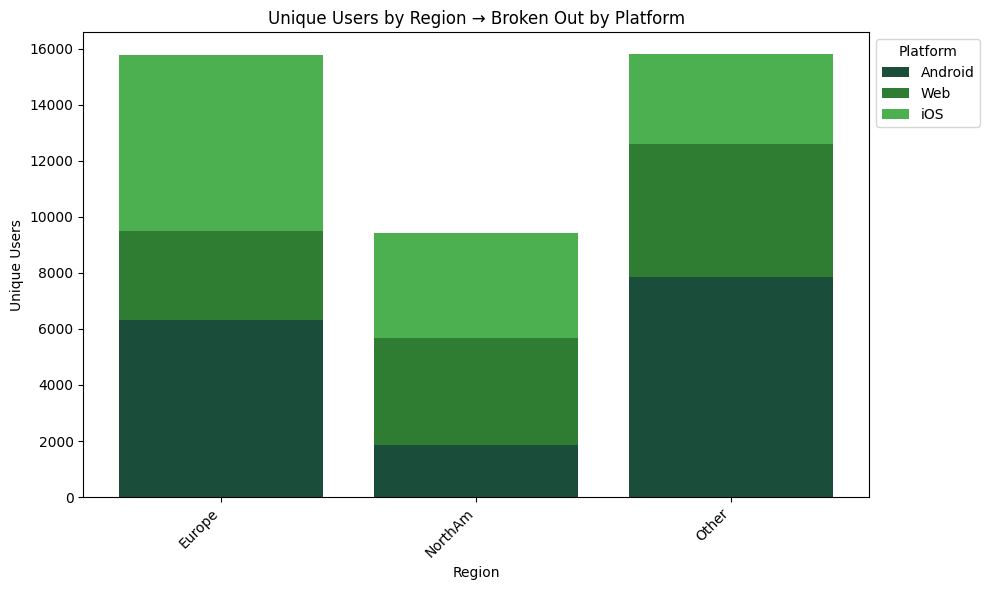

In [27]:
#Region vs. Platform

pivot = transfers.groupby(["region","platform"])["user_id"] \
                 .nunique().unstack(fill_value=0)

plt.figure(figsize=(10,6))
bottom = None
for i, col in enumerate(pivot.columns):
    vals = pivot[col].values
    plt.bar(
        pivot.index, vals,
        bottom=bottom,
        label=col,
        color=WISE_COLORS[i % len(WISE_COLORS)]
    )
    bottom = vals if bottom is None else bottom + vals

plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Unique Users")
plt.title("Unique Users by Region → Broken Out by Platform")
plt.legend(title="Platform", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

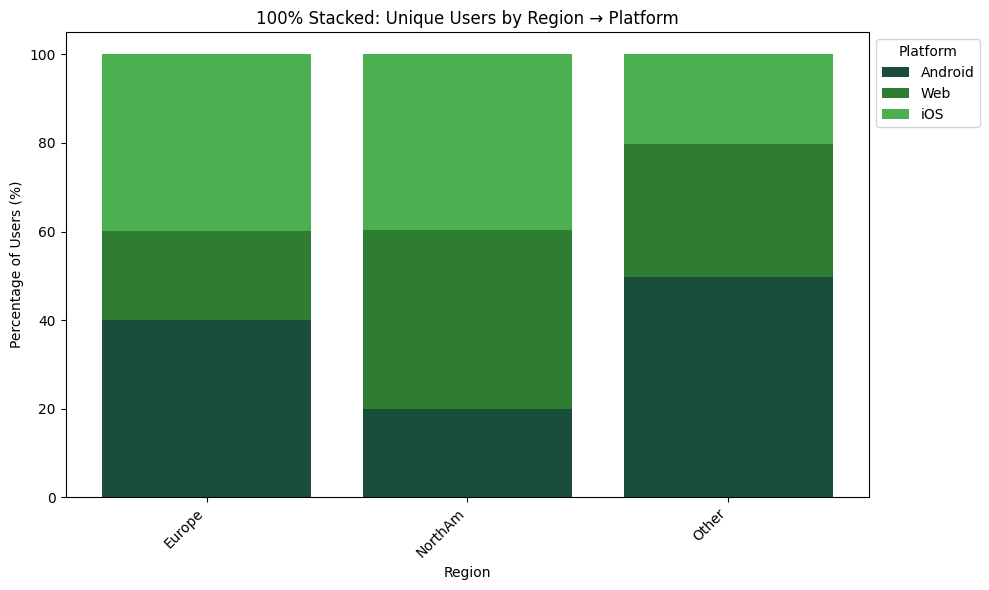

In [28]:
#stacked

pivot_perc = pivot.div(pivot.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10,6))
bottom = None
for i, col in enumerate(pivot_perc.columns):
    vals = pivot_perc[col].values
    plt.bar(
        pivot_perc.index, vals,
        bottom=bottom,
        label=col,
        color=WISE_COLORS[i % len(WISE_COLORS)]
    )
    bottom = vals if bottom is None else bottom + vals

plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Percentage of Users (%)")
plt.title("100% Stacked: Unique Users by Region → Platform")
plt.legend(title="Platform", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


#iOS is more prevalent in US and Europe. Web is the second favorite method in US

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/437470222.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  latest = transfers["created_dt"].dt.to_period("M").max().to_timestamp()
/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/437470222.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period("M").dt.to_timestamp()


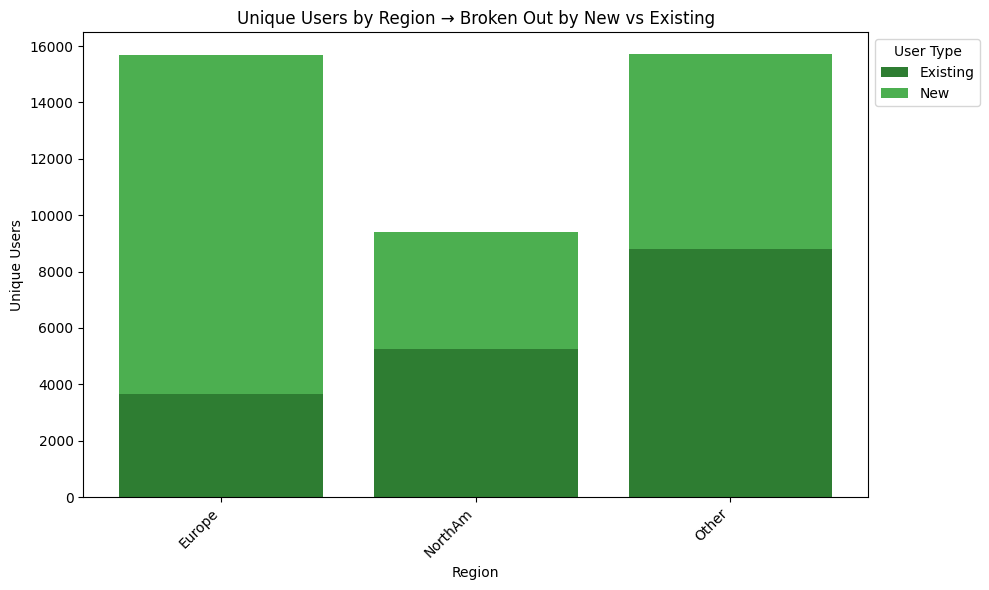

In [29]:
#New vs Existing

latest = transfers["created_dt"].dt.to_period("M").max().to_timestamp()
first_month = transfers.groupby("user_id")["created_dt"].min() \
                       .dt.to_period("M").dt.to_timestamp()
transfers["user_type"] = transfers["user_id"].map(
    first_month.eq(latest).map({True:"New", False:"Existing"})
)

pivot2 = transfers.groupby(["region","user_type"])["user_id"] \
                  .nunique().unstack(fill_value=0)

plt.figure(figsize=(10,6))
bottom = None
for i, col in enumerate(pivot2.columns):
    vals = pivot2[col].values
    plt.bar(
        pivot2.index, vals,
        bottom=bottom,
        label=col,
        color=WISE_COLORS[(i+1) % len(WISE_COLORS)]
    )
    bottom = vals if bottom is None else bottom + vals

plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Unique Users")
plt.title("Unique Users by Region → Broken Out by New vs Existing")
plt.legend(title="User Type", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/3579941311.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  latest = transfers["created_dt"].dt.to_period("M").max().to_timestamp()
/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/3579941311.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period("M").dt.to_timestamp()


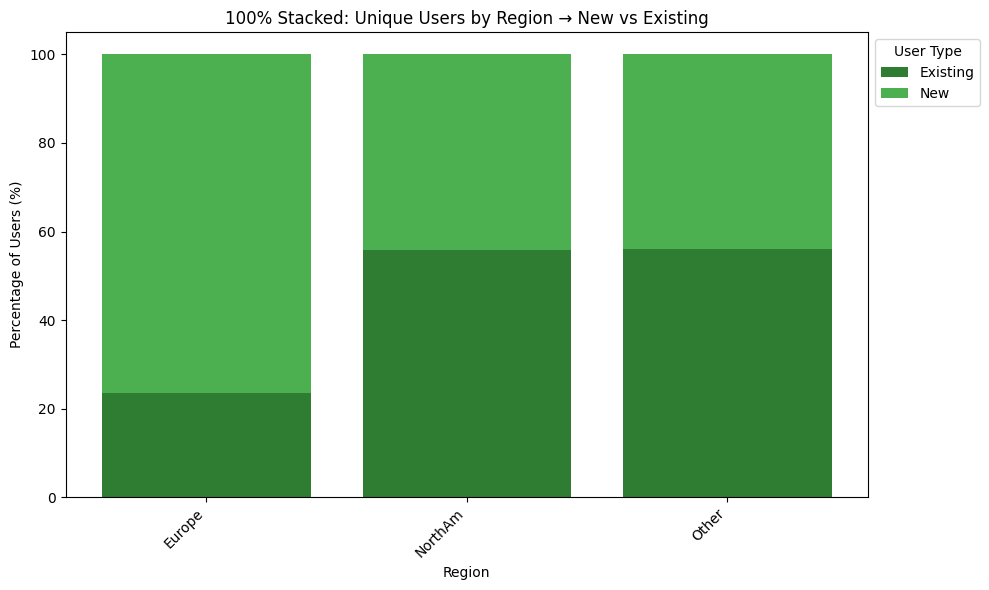

In [30]:
latest = transfers["created_dt"].dt.to_period("M").max().to_timestamp()
first_month = transfers.groupby("user_id")["created_dt"].min() \
                       .dt.to_period("M").dt.to_timestamp()
transfers["user_type"] = transfers["user_id"].map(
    first_month.eq(latest).map({True:"New", False:"Existing"})
)

pivot2 = transfers.groupby(["region","user_type"])["user_id"] \
                  .nunique().unstack(fill_value=0)

pivot2_perc = pivot2.div(pivot2.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10,6))
bottom = None
for i, col in enumerate(pivot2_perc.columns):
    vals = pivot2_perc[col].values
    plt.bar(
        pivot2_perc.index, vals,
        bottom=bottom,
        label=col,
        color=WISE_COLORS[(i+1) % len(WISE_COLORS)]
    )
    bottom = vals if bottom is None else bottom + vals

plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Percentage of Users (%)")
plt.title("100% Stacked: Unique Users by Region → New vs Existing")
plt.legend(title="User Type", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


#Several new users in Europe that is... interesting

## Over Time

In [31]:
## auxiliary function

def plot_ma7_sr_and_count(daily_df, dim, title=None):
    """
    Plots 7-day MA of success rate (solid) and transfer count (dashed)
    broken out by the categories in `dim`.
    
    daily_df must have columns: created_date, dim, created, funded, transferred
    """
    # 1) Aggregate per date & category
    agg = (
        daily_df
        .groupby(["created_date", dim], dropna=False)
        .agg(
            created       = ("created", "sum"),
            funded        = ("funded", "sum"),
            transferred   = ("transferred", "sum")
        )
        .reset_index()
    )
    # 2) Compute raw & MA7 metrics
    agg["success_rate"] = (agg["funded"] + agg["transferred"]) / agg["created"]
    agg = agg.sort_values(["created_date", dim])
    agg["sr_ma7"]    = agg.groupby(dim)["success_rate"] \
                          .transform(lambda s: s.rolling(7, min_periods=1).mean())
    agg["count_ma7"] = agg.groupby(dim)["created"] \
                          .transform(lambda s: s.rolling(7, min_periods=1).mean())

    # 3) Pivot wide
    pivot_sr    = agg.pivot(index="created_date", columns=dim, values="sr_ma7")
    pivot_count = agg.pivot(index="created_date", columns=dim, values="count_ma7")

    # 4) Plot dual-axis
    cmap = cm.get_cmap("tab10", len(pivot_sr.columns))
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()

    for i, cat in enumerate(pivot_sr.columns):
        color = cmap(i)
        ax1.plot(pivot_sr.index, pivot_sr[cat],
                 label=f"{cat} SR (MA7)",
                 color=color, linewidth=2)
        ax2.plot(pivot_count.index, pivot_count[cat],
                 label=f"{cat} Count (MA7)",
                 color=color, linestyle="--", linewidth=1)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Success Rate (7-day MA)")
    ax2.set_ylabel("Transfer Count (7-day MA)")
    if title:
        ax1.set_title(title)

    # Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
               loc="upper left", ncol=1)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

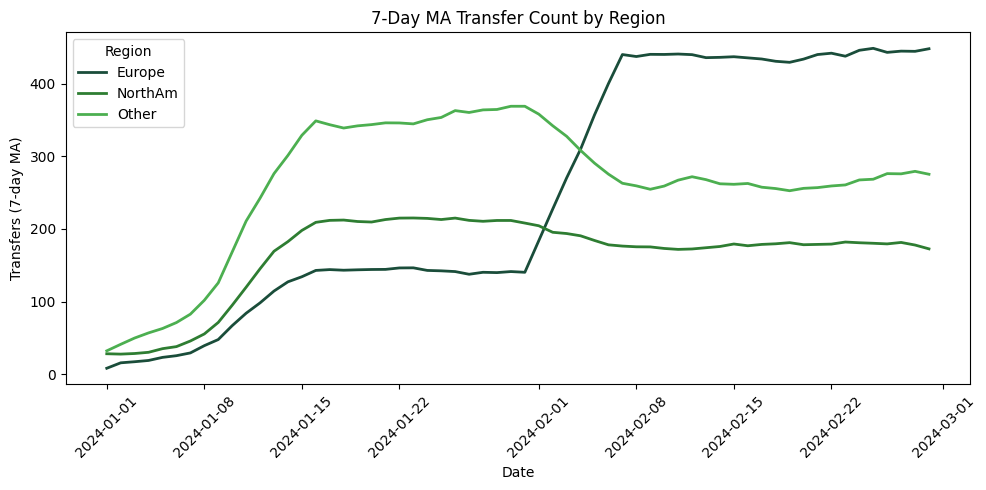

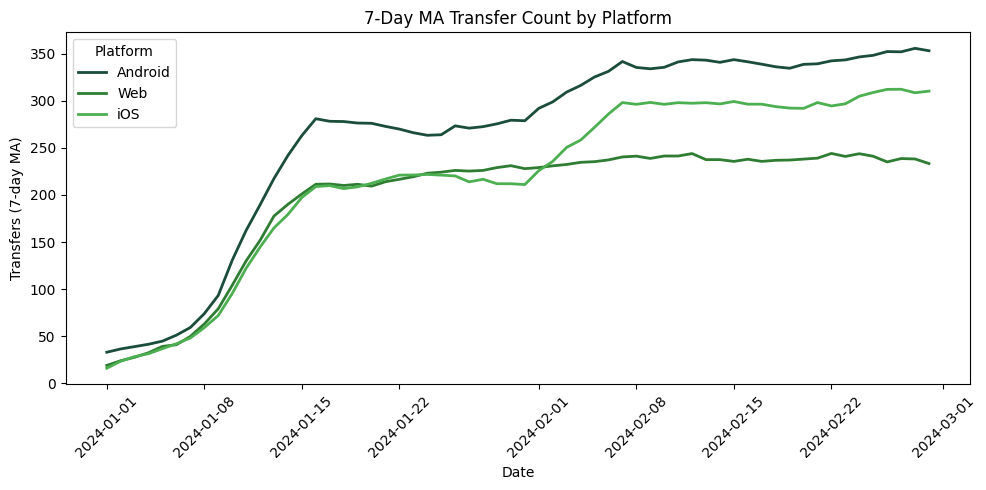

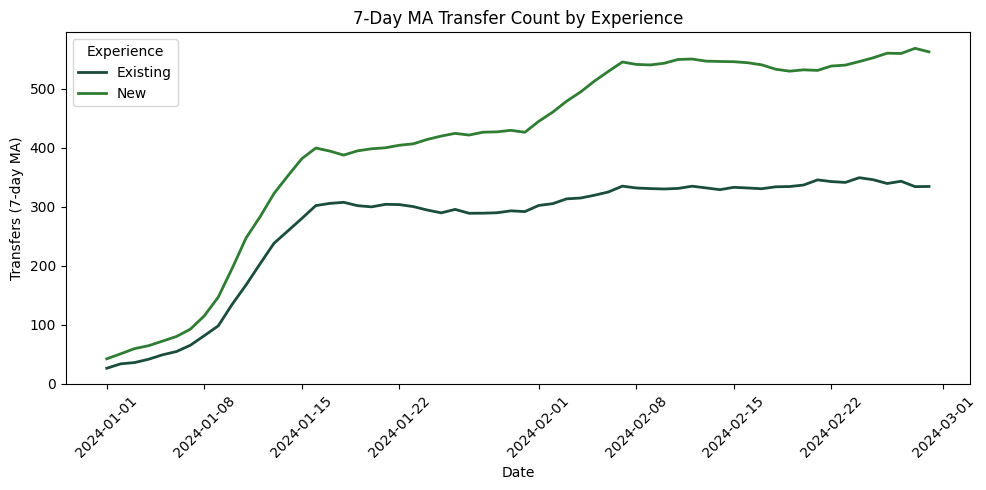

In [32]:
#Q1 does the composition keeps the same through time? 

dims = ["region", "platform", "experience"]

for dim in dims:
    # 1) Aggregate daily transfer counts
    tmp = (
        daily
        .groupby(["created_date", dim], dropna=False)["created"]
        .sum()
        .reset_index(name="count")
    )
    
    # 2) Compute 7-day MA of counts
    tmp = tmp.sort_values(["created_date", dim])
    tmp["count_ma7"] = tmp.groupby(dim)["count"] \
                          .transform(lambda s: s.rolling(7, min_periods=1).mean())
    
    # 3) Pivot so each category is a column
    pivot = tmp.pivot(index="created_date", columns=dim, values="count_ma7").fillna(0)
    
    # 4) Plot
    plt.figure(figsize=(10, 5))
    for i, cat in enumerate(pivot.columns):
        plt.plot(
            pivot.index,
            pivot[cat],
            label=str(cat),
            linewidth=2,
            color=WISE_COLORS[i % len(WISE_COLORS)]
        )
    
    plt.title(f"7-Day MA Transfer Count by {dim.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Transfers (7-day MA)")
    plt.xticks(rotation=45)
    plt.legend(title=dim.capitalize(), loc="best")
    plt.tight_layout()
    plt.show()

#Europe shows a spike in transfers after late january and it remains constant

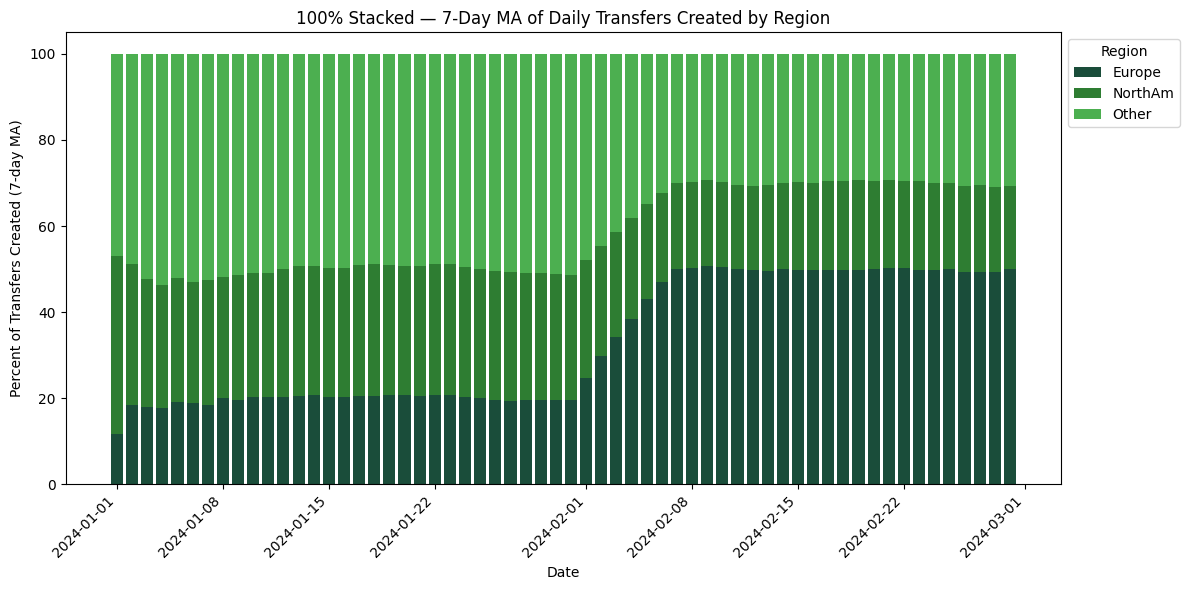

In [143]:
# 1) Compute daily created counts per region
daily_counts = (
    daily
    .groupby(["created_date", "region"], dropna=False)["transfer_created"]
    .sum()
    .reset_index(name="count")
)

# 2) Compute the 7-day MA per region
daily_counts = daily_counts.sort_values(["created_date", "region"])
daily_counts["count_ma7"] = (
    daily_counts
    .groupby("region")["count"]
    .transform(lambda s: s.rolling(7, min_periods=1).mean())
)

# 3) Pivot to wide form and normalize each day to 100%
pivot = daily_counts.pivot(index="created_date", columns="region", values="count_ma7").fillna(0)
percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

# 4) Plot 100% stacked bar chart with North America in grey
plt.figure(figsize=(12, 6))
bottom = None

for i, region in enumerate(percent.columns):
    vals = percent[region].values
    # Use grey for North America, otherwise WISE_COLORS
    color = "grey" if region == "North America" else WISE_COLORS[i % len(WISE_COLORS)]
    plt.bar(
        percent.index, vals,
        bottom=bottom,
        label=region,
        color=color
    )
    bottom = vals if bottom is None else bottom + vals

plt.xticks(rotation=45, ha="right")
plt.xlabel("Date")
plt.ylabel("Percent of Transfers Created (7-day MA)")
plt.title("100% Stacked — 7-Day MA of Daily Transfers Created by Region")
plt.legend(title="Region", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


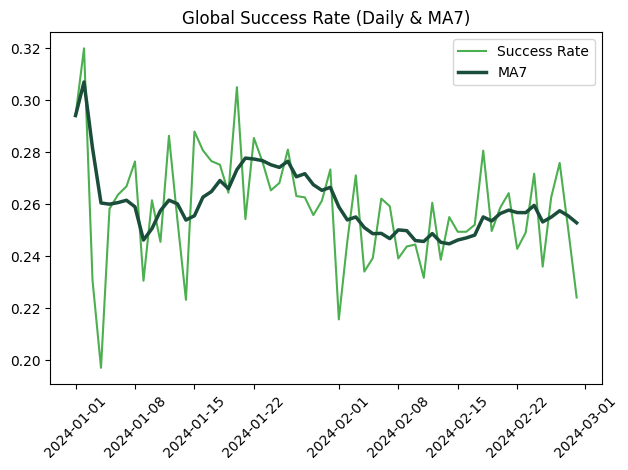

In [34]:
#Profile drift over time (global success rate w/ MA7)
plt.figure()
plt.plot(global_d["created_date"], global_d["success_rate"], label="Success Rate", linewidth=1.5, color=WISE_COLORS[2])
plt.plot(global_d["created_date"], global_d["success_rate_ma7"], label="MA7", linewidth=2.5, color=WISE_COLORS[0])
plt.legend()
plt.title("Global Success Rate (Daily & MA7)")
plt.xticks(rotation=45); plt.tight_layout()

#success rate tends to fall seasonally - we should check about week days 


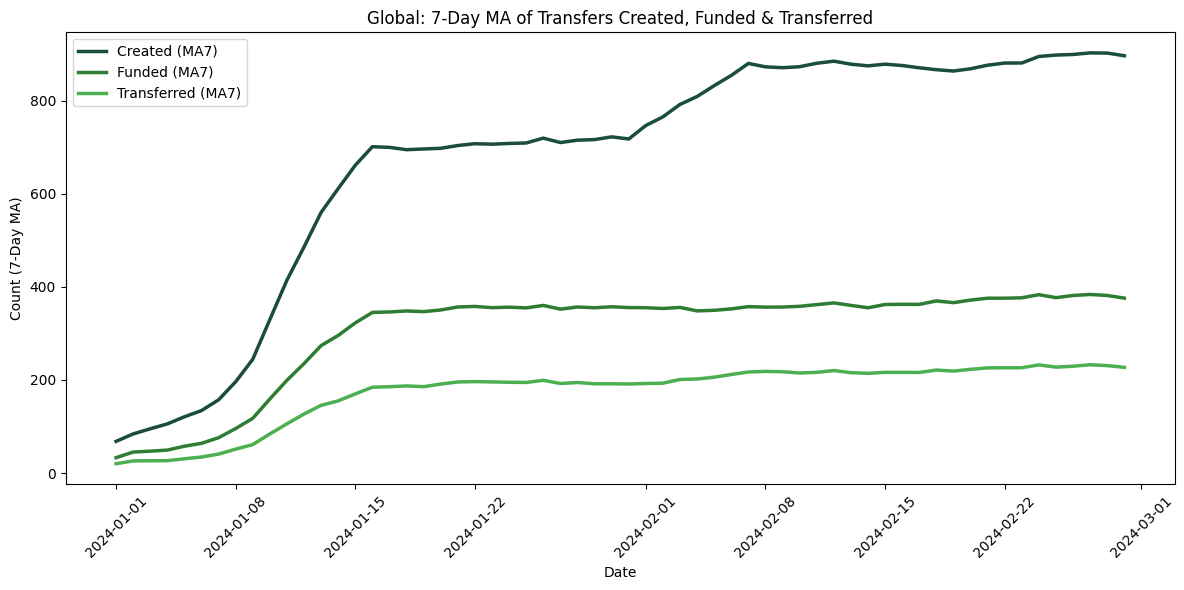

In [59]:
# 1) Aggregate global counts per day
global_data = (
    daily
    .groupby("created_date", dropna=False)[
        ["transfer_created", "transfer_funded", "transfer_transferred"]
    ]
    .sum()
    .reset_index()
    .sort_values("created_date")
)

# 2) Compute 7-day MA for each metric
for col in ["transfer_created", "transfer_funded", "transfer_transferred"]:
    global_data[f"{col}_ma7"] = (
        global_data[col]
        .rolling(7, min_periods=1)
        .mean()
    )

# 3) Plot with correct MA7 column names
plt.figure(figsize=(12, 6))
plt.plot(
    global_data["created_date"],
    global_data["transfer_created_ma7"],
    label="Created (MA7)",
    color=WISE_COLORS[0],
    linewidth=2.5
)
plt.plot(
    global_data["created_date"],
    global_data["transfer_funded_ma7"],
    label="Funded (MA7)",
    color=WISE_COLORS[1],
    linewidth=2.5
)
plt.plot(
    global_data["created_date"],
    global_data["transfer_transferred_ma7"],
    label="Transferred (MA7)",
    color=WISE_COLORS[2],
    linewidth=2.5
)

plt.title("Global: 7-Day MA of Transfers Created, Funded & Transferred")
plt.xlabel("Date")
plt.ylabel("Count (7-Day MA)")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [35]:
def plot_agg_ma7(dim, title):
    # 1) Sum up the counts per day & category
    agg = (
        daily
        .groupby(["created_date", dim], dropna=False)[["created", "funded", "transferred"]]
        .sum()
        .reset_index()
    )
    # 2) Compute success rate
    agg["success_rate"] = (agg["funded"]) / agg["created"]

    # 3) Compute 7-day MA of that rate
    agg = agg.sort_values(["created_date", dim])
    agg["sr_ma7"] = (
        agg
        .groupby(dim)["success_rate"]
        .transform(lambda s: s.rolling(7, min_periods=1).mean())
    )

    # 4) Pivot: one column per category
    pivot = agg.pivot(index="created_date", columns=dim, values="sr_ma7")

    # 5) Choose distinct colors
    from matplotlib import cm
    cmap = cm.get_cmap("tab10", len(pivot.columns))

    # 6) Plot
    plt.figure(figsize=(10, 5))
    for i, cat in enumerate(pivot.columns):
        plt.plot(
            pivot.index,
            pivot[cat],
            label=str(cat),
            linewidth=2.5,
            color=cmap(i),
        )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("7-Day MA Success Rate")
    plt.xticks(rotation=45)
    plt.legend(title=dim.capitalize(), loc="best")
    plt.tight_layout()
    plt.show()

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/281280374.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(pivot.columns))


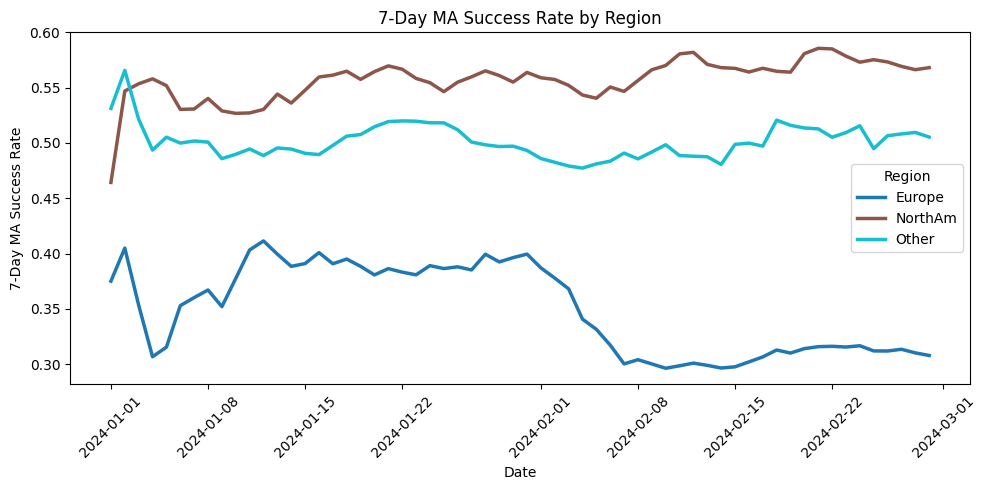

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/281280374.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(pivot.columns))


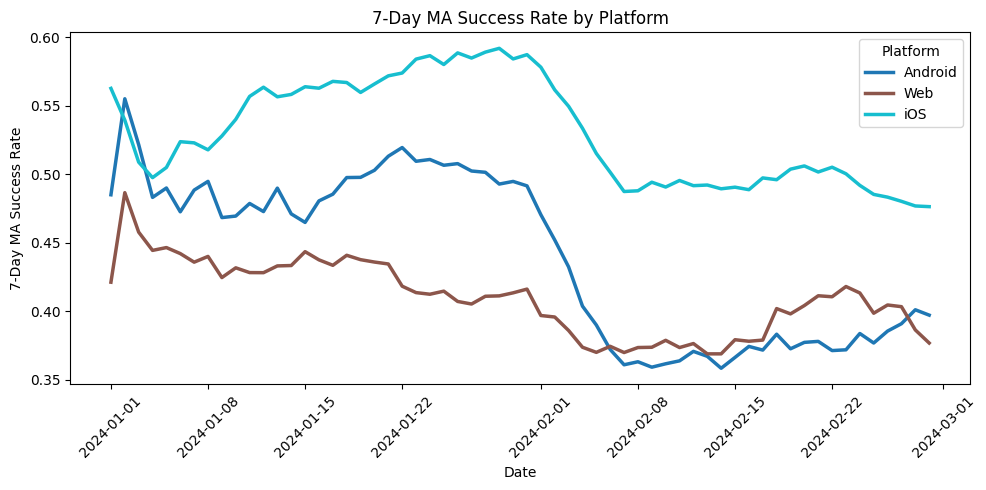

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/281280374.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(pivot.columns))


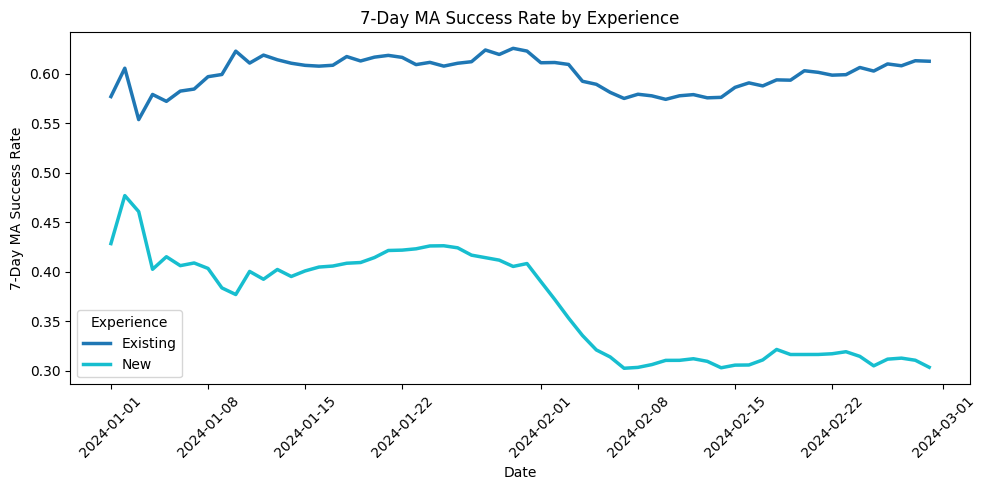

In [36]:

plot_agg_ma7("region",     "7-Day MA Success Rate by Region")
plot_agg_ma7("platform",   "7-Day MA Success Rate by Platform")
plot_agg_ma7("experience", "7-Day MA Success Rate by Experience")

#Cha-Ching! After Early checks we figured out that Europe has some sort of bug starting in february

In [37]:
daily

,created_date,region,platform,experience,created,funded,transferred,failure_rate,success_rate,success_rate_ma7
0,2024-01-01,Europe,Android,Existing,1,0,0,1.000000,0.000000,0.000000
16,2024-01-02,Europe,Android,Existing,9,7,7,0.222222,0.777778,0.388889
34,2024-01-03,Europe,Android,Existing,5,1,1,0.800000,0.200000,0.325926
52,2024-01-04,Europe,Android,Existing,3,1,0,1.000000,0.000000,0.244444
69,2024-01-05,Europe,Android,Existing,13,7,4,0.692308,0.307692,0.257094
...,...,...,...,...,...,...,...,...,...,...
1004,2024-02-25,Other,iOS,New,56,20,8,0.857143,0.142857,0.188603
1022,2024-02-26,Other,iOS,New,53,29,10,0.811321,0.188679,0.184199
1040,2024-02-27,Other,iOS,New,40,17,11,0.725000,0.275000,0.205169
1058,2024-02-28,Other,iOS,New,41,15,8,0.804878,0.195122,0.203144


In [49]:
daily.columns

Index(['transfer_id', 'transfer_key', 'user_id', 'region', 'platform',
       'experience', 'created_dt', 'funded_dt', 'transferred_dt',
       'transfer_created', 'transfer_funded', 'transfer_transferred',
       'sequence_pattern', 'status', 'user_type', 'created_date'],
      dtype='object')

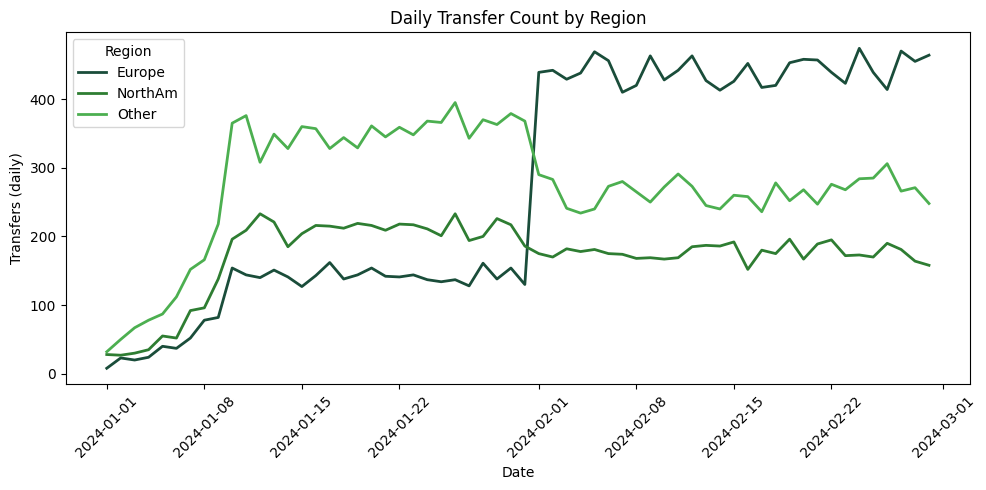

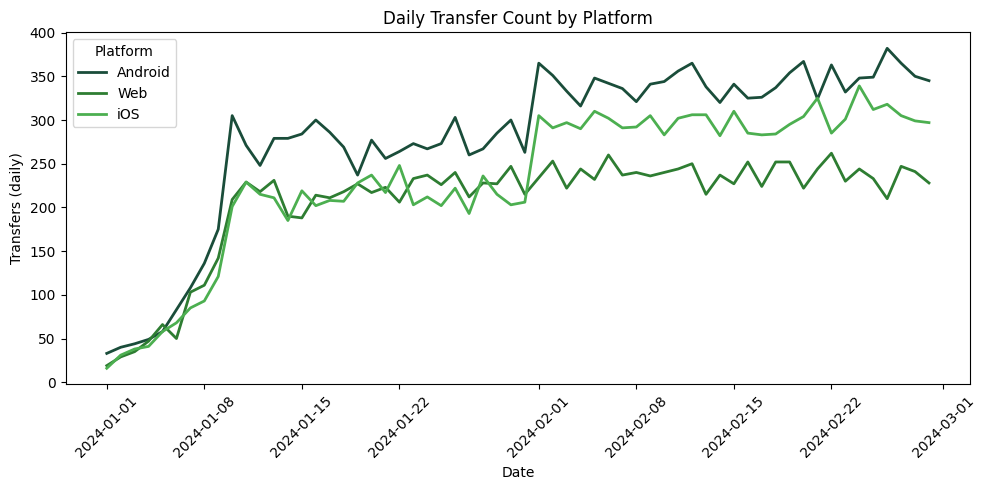

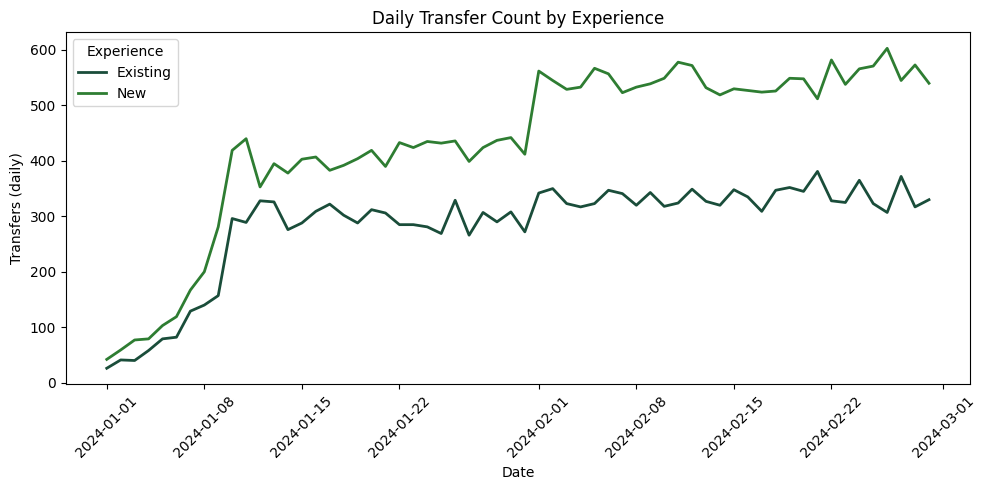

In [50]:
#let's do it without the window softness so we can have the clarity of when it started

dims = ["region", "platform", "experience"]

for dim in dims:
    # 1) Aggregate daily transfer counts
    tmp = (
        daily
        .groupby(["created_date", dim], dropna=False)["transfer_created"]
        .sum()
        .reset_index(name="count")
    )
    
    # 2) Pivot so each category is a column
    pivot = tmp.pivot(index="created_date", columns=dim, values="count").fillna(0)
    
    # 3) Plot raw daily counts
    plt.figure(figsize=(10, 5))
    for i, cat in enumerate(pivot.columns):
        plt.plot(
            pivot.index,
            pivot[cat],
            label=str(cat),
            linewidth=2,
            color=WISE_COLORS[i % len(WISE_COLORS)]
        )
    
    plt.title(f"Daily Transfer Count by {dim.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Transfers (daily)")
    plt.xticks(rotation=45)
    plt.legend(title=dim.capitalize(), loc="best")
    plt.tight_layout()
    plt.show()

In [51]:
daily_counts = (
    daily
    .groupby(["created_date", "region"], dropna=False)["transfer_created"]
    .sum()
    .reset_index(name="count")
)

eu_success = (
    daily[daily["region"] == "Europe"]
    .groupby("created_date", dropna=False)["transfer_transferred"]
    .sum()
    .reset_index(name="eu_transferred"))

merged = daily_counts.merge(
    eu_success,
    on="created_date",
    how="left"
).fillna({"eu_transferred": 0})

# Inspect

merged['success'] = merged['eu_transferred']/merged['count']
merged[merged.region == "Europe"].head(50)

#Odd Enough, success rate falls from around 30 to around 20% - but it alone does not justify what might be happening.

,created_date,region,count,eu_transferred,success
0,2024-01-01,Europe,8,3,0.375000
3,2024-01-02,Europe,23,8,0.347826
6,2024-01-03,Europe,20,5,0.250000
9,2024-01-04,Europe,24,1,0.041667
12,2024-01-05,Europe,40,11,0.275000
15,2024-01-06,Europe,37,16,0.432432
18,2024-01-07,Europe,52,19,0.365385
21,2024-01-08,Europe,78,28,0.358974
24,2024-01-09,Europe,82,22,0.268293
27,2024-01-10,Europe,154,55,0.357143


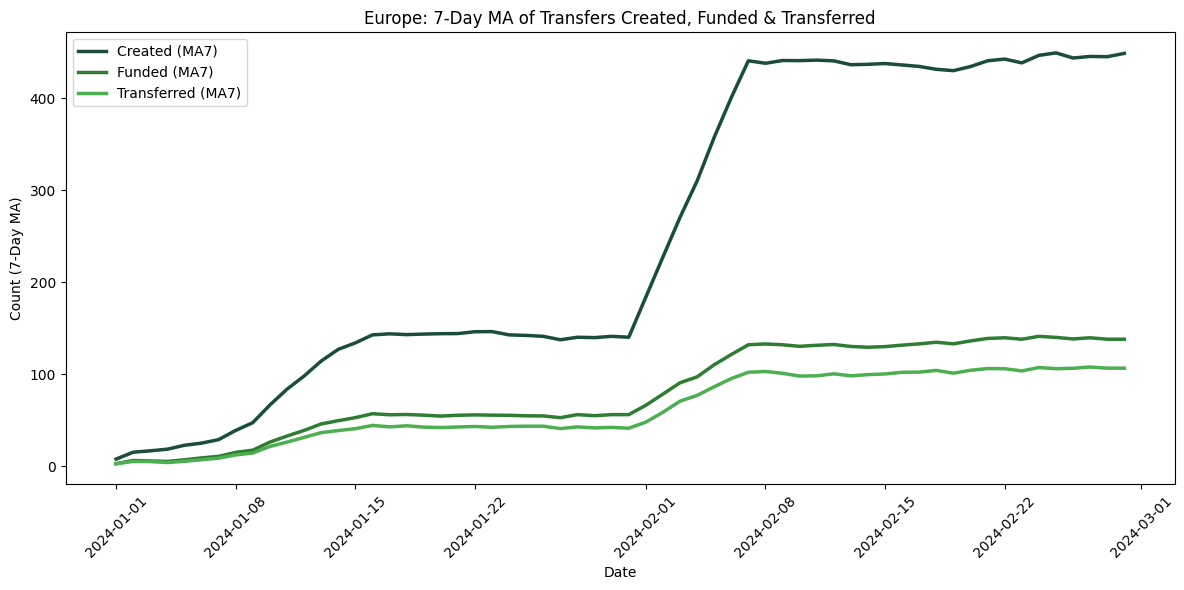

In [40]:
eu = (
    daily[daily["region"] == "Europe"]
    .groupby("created_date", dropna=False)[["created", "funded", "transferred"]]
    .sum()
    .reset_index()
    .sort_values("created_date")
)

# 3) Compute 7-day MA for each metric
for col in ["created", "funded", "transferred"]:
    eu[f"{col}_ma7"] = eu[col].rolling(7, min_periods=1).mean()

# 4) Plot
plt.figure(figsize=(12, 6))
plt.plot(eu["created_date"], eu["created_ma7"],
         label="Created (MA7)", color=WISE_COLORS[0], linewidth=2.5)
plt.plot(eu["created_date"], eu["funded_ma7"],
         label="Funded (MA7)", color=WISE_COLORS[1], linewidth=2.5)
plt.plot(eu["created_date"], eu["transferred_ma7"],
         label="Transferred (MA7)", color=WISE_COLORS[2], linewidth=2.5)

plt.title("Europe: 7-Day MA of Transfers Created, Funded & Transferred")
plt.xlabel("Date")
plt.ylabel("Count (7-Day MA)")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

At the same time european attempts spike, we see a huge drop in new sucess rate. 

Let's repeat the previous analysis without europe

In [41]:
daily_wo_europe = daily[daily["region"] != "Europe"]

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/2263458676.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(pivot.columns))


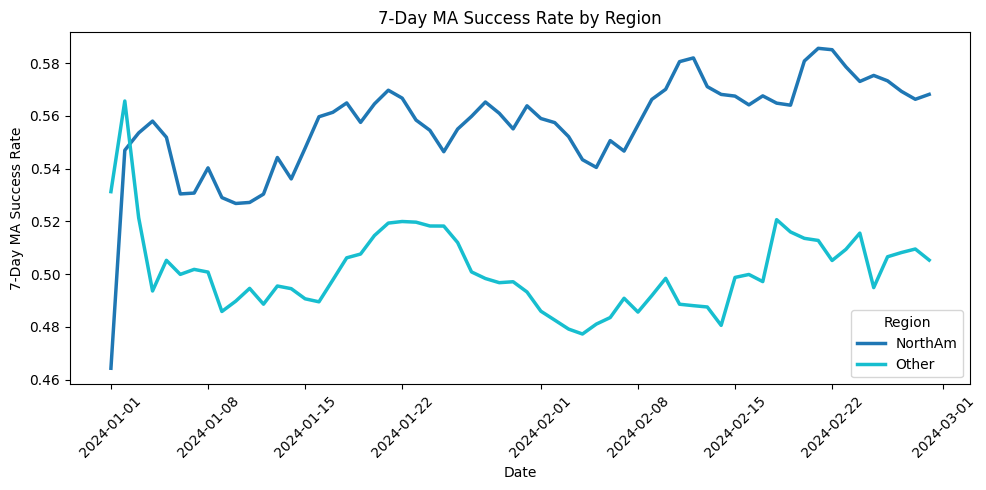

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/2263458676.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(pivot.columns))


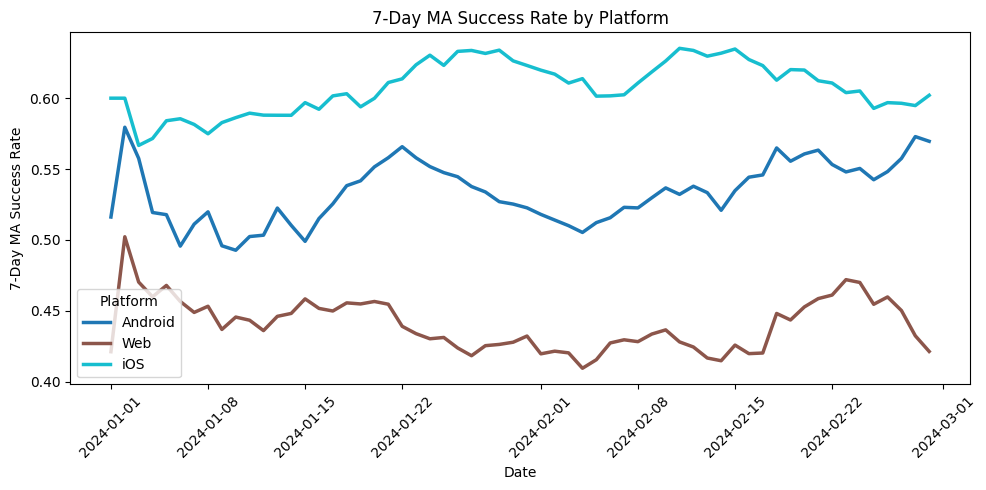

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/2263458676.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(pivot.columns))


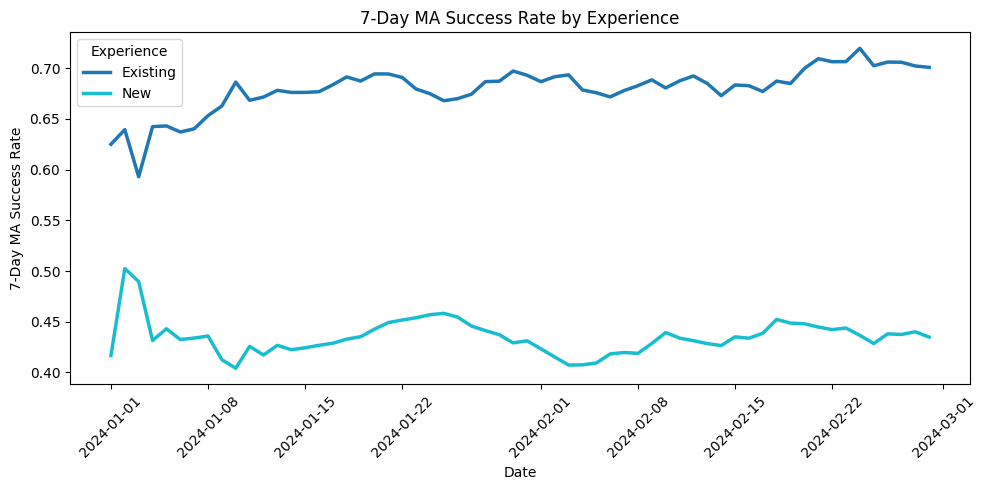

In [135]:
def plot_agg_ma7_wo_europe(dim, title):
    # 1) Sum up the counts per day & category
    agg = (
        daily_wo_europe
        .groupby(["created_date", dim], dropna=False)[["created", "funded", "transferred"]]
        .sum()
        .reset_index()
    )
    # 2) Compute success rate
    agg["success_rate"] = (agg["funded"]) / agg["created"]  #remember that I'm looking for what is not a failure.

    # 3) Compute 7-day MA of that rate
    agg = agg.sort_values(["created_date", dim])
    agg["sr_ma7"] = (
        agg
        .groupby(dim)["success_rate"]
        .transform(lambda s: s.rolling(7, min_periods=1).mean())
    )

    # 4) Pivot: one column per category
    pivot = agg.pivot(index="created_date", columns=dim, values="sr_ma7")

    # 5) Choose distinct colors
    from matplotlib import cm
    cmap = cm.get_cmap("tab10", len(pivot.columns))

    # 6) Plot
    plt.figure(figsize=(10, 5))
    for i, cat in enumerate(pivot.columns):
        plt.plot(
            pivot.index,
            pivot[cat],
            label=str(cat),
            linewidth=2.5,
            color=cmap(i),
        )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("7-Day MA Success Rate")
    plt.xticks(rotation=45)
    plt.legend(title=dim.capitalize(), loc="best")
    plt.tight_layout()
    plt.show()

plot_agg_ma7_wo_europe("region",     "7-Day MA Success Rate by Region")
plot_agg_ma7_wo_europe("platform",   "7-Day MA Success Rate by Platform")
plot_agg_ma7_wo_europe("experience", "7-Day MA Success Rate by Experience")



<Figure size 1600x900 with 0 Axes>

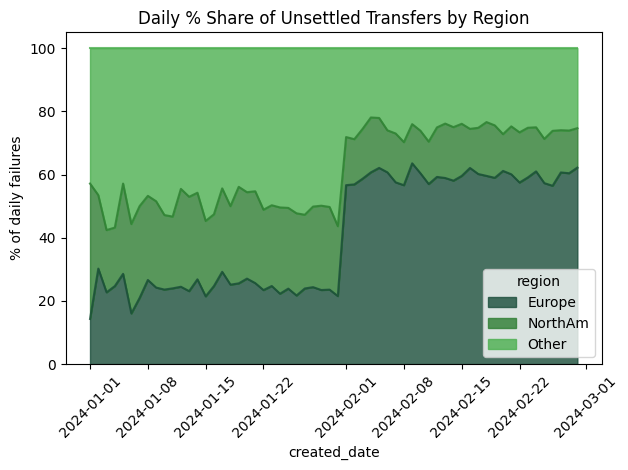

In [60]:
# So, Basically Europe is driving the performance really down almost 60% of the unsettled transactions come from europe.

# 2) Daily % by region
# First compute daily counts of unsettled by region
daily = transfers.copy()
daily["created_date"] = daily["created_dt"].dt.date

df = (
    daily[daily["status"] == "unsettled"]
    .groupby(["created_date","region"])["transfer_id"]
    .count()
    .reset_index(name="fails")
)

# Pivot to wide, normalize each day
pivot = df.pivot(index="created_date", columns="region", values="fails").fillna(0)
perc = pivot.div(pivot.sum(axis=1), axis=0).mul(100)

# Plot as 100% stacked area
plt.figure(figsize=(16, 9))
perc.plot.area(
    stacked=True,
    color=[WISE_COLORS[i] for i in range(len(perc.columns))],
    alpha=0.8,
    legend=True
)
plt.ylabel("% of daily failures")
plt.title("Daily % Share of Unsettled Transfers by Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# What have we learned:

- The product has got considerable attention for regions outside of North America (where Mexico and the USA are), however, part of that seems to be a bug or a very unique behavior
- Europe saw a spike of 83% in Jan 9th and another of 239% (130 to 439) in Feb 2nd - the sucess rate follows around 25-30% in general for this audience. 

## Pivots 

now let's compare those variables 2x2 

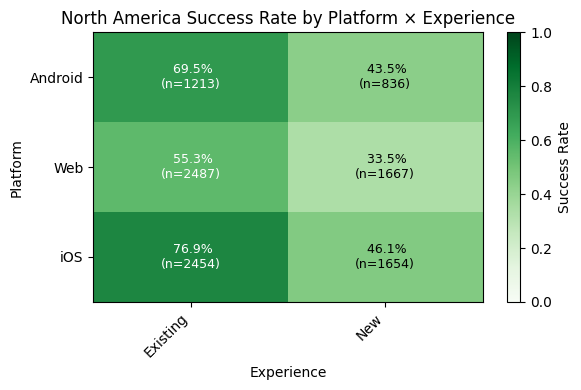

In [79]:

# 1) Filter to North America
na = transfers[transfers["region"] == "NorthAm"].copy()
na["success_event"] = (na["status"] != "unsettled").astype(int)


# Build success‐rate pivot
pivot_sr = (
    na
    .groupby(["platform","experience"], dropna=False)
    .agg(success_rate=("success_event","mean"))
    .reset_index()
    .pivot(index="platform", columns="experience", values="success_rate")
)

# Build counts pivot (for annotation)
pivot_n = (
    na
    .groupby(["platform","experience"], dropna=False)
    .size()
    .unstack(fill_value=0)
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(6,4))
cax = ax.imshow(pivot_sr, aspect="auto", cmap="Greens", vmin=0, vmax=1)
fig.colorbar(cax, label="Success Rate")

# Tick labels
ax.set_xticks(np.arange(len(pivot_sr.columns)))
ax.set_yticks(np.arange(len(pivot_sr.index)))
ax.set_xticklabels(pivot_sr.columns, rotation=45, ha="right")
ax.set_yticklabels(pivot_sr.index)

# Annotate each cell
for i, plat in enumerate(pivot_sr.index):
    for j, exp in enumerate(pivot_sr.columns):
        sr = pivot_sr.loc[plat, exp]
        n  = pivot_n.loc[plat, exp]
        text = f"{sr*100:>5.1f}%\n(n={n})"
        ax.text(j, i, text,
                ha="center", va="center",
                color="white" if sr > 0.5 else "black",
                fontsize=9)

ax.set_title("North America Success Rate by Platform × Experience")
ax.set_xlabel("Experience")
ax.set_ylabel("Platform")
plt.tight_layout()
plt.show()

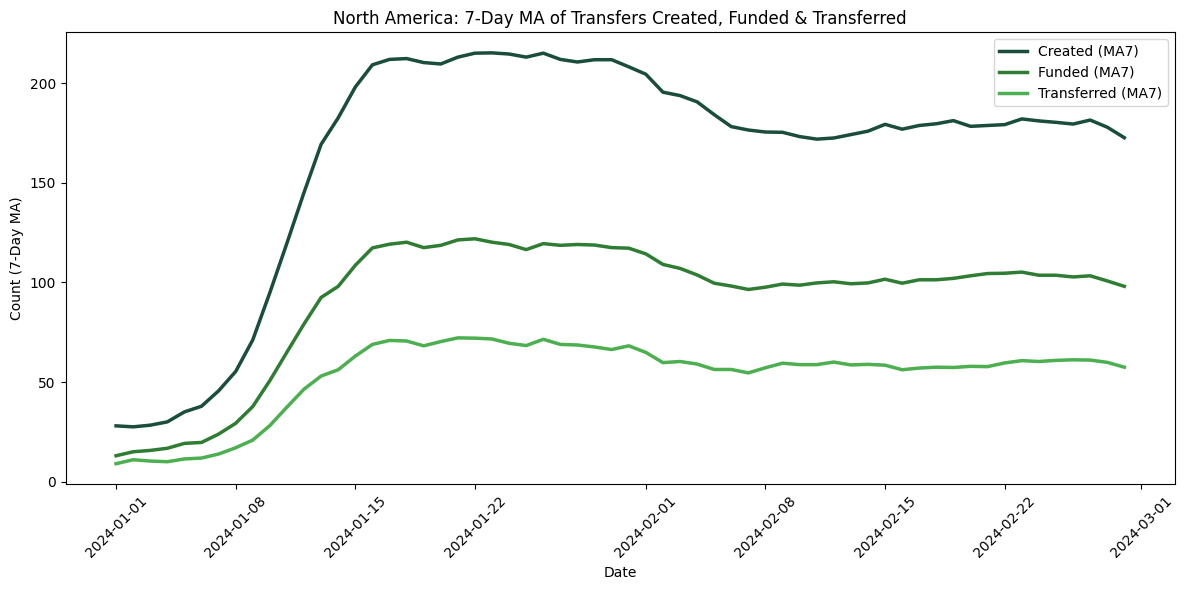

In [89]:
# 1) Filter & aggregate for North America
na_grouped = (
    daily[daily["region"] == "NorthAm"]  # full name
    .groupby("created_date", dropna=False)[
        ["transfer_created", "transfer_funded", "transfer_transferred"]
    ]
    .sum()
    .reset_index()
    .sort_values("created_date")
)

# 2) Compute 7-day MA for each transfer metric
for col in ["transfer_created", "transfer_funded", "transfer_transferred"]:
    na_grouped[f"{col}_ma7"] = na_grouped[col].rolling(7, min_periods=1).mean()

# 3) Plot the correct MA7 columns
plt.figure(figsize=(12, 6))
plt.plot(
    na_grouped["created_date"],
    na_grouped["transfer_created_ma7"],  # use full column name
    label="Created (MA7)",
    color=WISE_COLORS[0],
    linewidth=2.5
)
plt.plot(
    na_grouped["created_date"],
    na_grouped["transfer_funded_ma7"],
    label="Funded (MA7)",
    color=WISE_COLORS[1],
    linewidth=2.5
)
plt.plot(
    na_grouped["created_date"],
    na_grouped["transfer_transferred_ma7"],
    label="Transferred (MA7)",
    color=WISE_COLORS[2],
    linewidth=2.5
)

plt.title("North America: 7-Day MA of Transfers Created, Funded & Transferred")
plt.xlabel("Date")
plt.ylabel("Count (7-Day MA)")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

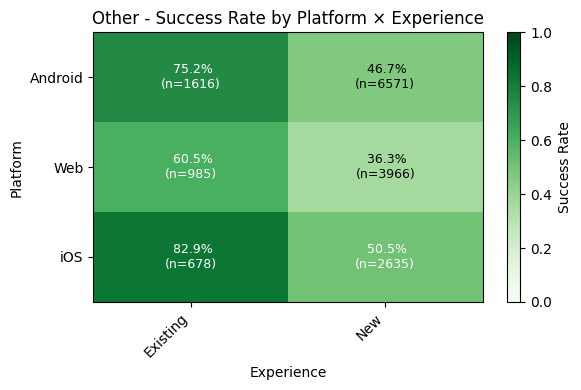

In [77]:

# 1) Filter to Other
Other = transfers[transfers["region"] == "Other"].copy()
Other["success_event"] = (Other["status"] != "unsettled").astype(int)


# Build success‐rate pivot
pivot_sr = (
    Other
    .groupby(["platform","experience"], dropna=False)
    .agg(success_rate=("success_event","mean"))
    .reset_index()
    .pivot(index="platform", columns="experience", values="success_rate")
)

# Build counts pivot (for annotation)
pivot_n = (
    Other
    .groupby(["platform","experience"], dropna=False)
    .size()
    .unstack(fill_value=0)
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(6,4))
cax = ax.imshow(pivot_sr, aspect="auto", cmap="Greens", vmin=0, vmax=1)
fig.colorbar(cax, label="Success Rate")

# Tick labels
ax.set_xticks(np.arange(len(pivot_sr.columns)))
ax.set_yticks(np.arange(len(pivot_sr.index)))
ax.set_xticklabels(pivot_sr.columns, rotation=45, ha="right")
ax.set_yticklabels(pivot_sr.index)

# Annotate each cell
for i, plat in enumerate(pivot_sr.index):
    for j, exp in enumerate(pivot_sr.columns):
        sr = pivot_sr.loc[plat, exp]
        n  = pivot_n.loc[plat, exp]
        text = f"{sr*100:>5.1f}%\n(n={n})"
        ax.text(j, i, text,
                ha="center", va="center",
                color="white" if sr > 0.5 else "black",
                fontsize=9)

ax.set_title("Other - Success Rate by Platform × Experience")
ax.set_xlabel("Experience")
ax.set_ylabel("Platform")
plt.tight_layout()
plt.show()

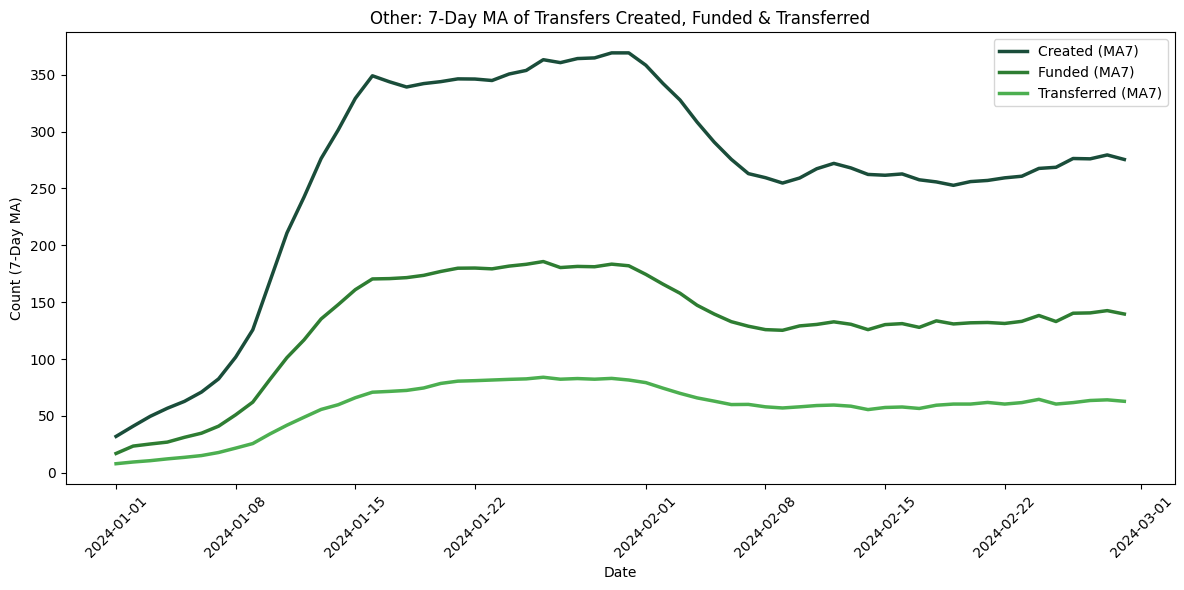

In [91]:
# 1) Filter & aggregate for North America
other_grouped = (
    daily[daily["region"] == "Other"]  # full name
    .groupby("created_date", dropna=False)[
        ["transfer_created", "transfer_funded", "transfer_transferred"]
    ]
    .sum()
    .reset_index()
    .sort_values("created_date")
)

# 2) Compute 7-day MA for each transfer metric
for col in ["transfer_created", "transfer_funded", "transfer_transferred"]:
    other_grouped[f"{col}_ma7"] = other_grouped[col].rolling(7, min_periods=1).mean()

# 3) Plot the correct MA7 columns
plt.figure(figsize=(12, 6))
plt.plot(
    other_grouped["created_date"],
    other_grouped["transfer_created_ma7"],  # use full column name
    label="Created (MA7)",
    color=WISE_COLORS[0],
    linewidth=2.5
)
plt.plot(
    other_grouped["created_date"],
    other_grouped["transfer_funded_ma7"],
    label="Funded (MA7)",
    color=WISE_COLORS[1],
    linewidth=2.5
)
plt.plot(
    other_grouped["created_date"],
    other_grouped["transfer_transferred_ma7"],
    label="Transferred (MA7)",
    color=WISE_COLORS[2],
    linewidth=2.5
)

plt.title("Other: 7-Day MA of Transfers Created, Funded & Transferred")
plt.xlabel("Date")
plt.ylabel("Count (7-Day MA)")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Friction Analysis

- What happens when a customers don't have a transfer settled. Do they try again?

In [106]:
# 1. Flag for unsettled (failure at creation stage)
transfers["failed"] = transfers["status"] == "unsettled"
transfers["next_exists"] = transfers.groupby("user_id")["transfer_id"].shift(-1).notnull()


total_failures = transfers["failed"].sum()
print(f"1) Total failures (unsettled transfers): {total_failures}")

1) Total failures (unsettled transfers): 23784


In [98]:
#Sort by user & time
transfers = transfers.sort_values(["user_id","created_dt"])

# B) Carry forward the failure flag and platform of the *previous* transfer
transfers["prev_failed"]   = transfers.groupby("user_id")["failed"].shift(1).fillna(False)
transfers["prev_platform"] = transfers.groupby("user_id")["platform"].shift(1)

# C) Check how many “retries” we have (any transfer that follows a failure)
total_retries = transfers["prev_failed"].sum()
print(f"2) Total retries after a failure: {total_retries}")


2) Total retries after a failure: 1029


/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/3205097590.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transfers["prev_failed"]   = transfers.groupby("user_id")["failed"].shift(1).fillna(False)


In [99]:
retry_rows = transfers[transfers["prev_failed"]]
print(f"   Sample retry rows:\n", retry_rows.head(3)[["user_id","created_dt","failed","prev_failed"]])

   Sample retry rows:
        user_id                created_dt  failed  prev_failed
27   1000532.0 2024-02-29 00:00:00+00:00   False         True
88   1001901.0 2024-02-18 00:00:00+00:00   False         True
103  1002220.0 2024-02-01 00:00:00+00:00    True         True


In [101]:
# A retry counts as a switch if the new platform differs from the previous one
mask_switch = retry_rows["platform"] != retry_rows["prev_platform"]
switch_rows = retry_rows[mask_switch]

total_switches = mask_switch.sum()
print(f"3) Of those retries, platform‐switching retries: {total_switches}")

3) Of those retries, platform‐switching retries: 350


In [102]:
overall_retry_rate   = total_retries / total_failures if total_failures else 0
overall_switch_rate  = total_switches / total_retries if total_retries else 0

print(f"4) Overall retry‐after‐failure rate: {overall_retry_rate:.1%}")
print(f"   Overall platform‐switch‐after‐failure rate: {overall_switch_rate:.1%}")

4) Overall retry‐after‐failure rate: 4.3%
   Overall platform‐switch‐after‐failure rate: 34.0%


In [103]:
dims = ["region","platform","experience"]

for dim in dims:
    grp = retry_rows.groupby(dim).size().rename("num_retries")
    sw  = switch_rows.groupby(dim).size().rename("num_switches")
    df  = pd.concat([grp, sw], axis=1).fillna(0).astype(int)
    df["retry_rate"]  = df["num_retries"]  / total_retries
    df["switch_rate"] = df["num_switches"] / df["num_retries"].replace(0, pd.NA)
    print(f"\nBy {dim.capitalize()}:")
    display(df)



By Region:


,num_retries,num_switches,retry_rate,switch_rate
region,,,,
Europe,358,160,0.347911,0.446927
NorthAm,223,69,0.216715,0.309417
Other,448,121,0.435374,0.270089



By Platform:


,num_retries,num_switches,retry_rate,switch_rate
platform,,,,
Android,405,118,0.393586,0.291358
Web,322,97,0.312925,0.301242
iOS,302,135,0.293489,0.447020



By Experience:


,num_retries,num_switches,retry_rate,switch_rate
experience,,,,
Existing,371,143,0.360544,0.385445
New,658,207,0.639456,0.314590


#### New/Existing Retries

In [107]:
failed = transfers[transfers["failed"]].copy()

agg_ne = (
    failed
    .groupby("is_new_user_month", dropna=False)
    .agg(
        total_failures = ("failed","count"),
        retries_after  = ("next_exists","sum")
    )
    .assign(retry_rate = lambda df: df["retries_after"] / df["total_failures"])
)

# 5) Rename index for clarity
agg_ne.index = ["Existing users", "New users"]
print(agg_ne)

                total_failures  retries_after  retry_rate
Existing users            1066             35    0.032833
New users                22718            994    0.043754


## recurrency

- we will consider recurring custoemrs customers who have at least a second transfer funded

In [113]:
funded_counts = (
    transfers[transfers["transfer_funded"]]
    .groupby("user_id")["transfer_id"]
    .count()
    .rename("funded_tx_count")
)

# 3) Build a user‐level table and flag recurring customers
users = funded_counts.reset_index()
users["is_recur"] = users["funded_tx_count"] >= 2

# 4) Overall recurrence rate
overall_rate = users["is_recur"].mean()
print(f"Overall recurring customer rate (≥2 funded transfers): {overall_rate:.1%}")

# 5) Bring in segment metadata (region / platform / experience)
meta = transfers.drop_duplicates("user_id")[["user_id","region","platform","experience"]]
users = users.merge(meta, on="user_id", how="left")

# 6) Recurrence rate by segment
for dim in ["region","platform","experience"]:
    agg = (
        users
        .groupby(dim)
        .agg(
            total_users = ("user_id", "count"),
            recur_users = ("is_recur", "sum")
        )
        .assign(recur_rate = lambda df: df["recur_users"] / df["total_users"])
    )
    print(f"\nRecurring rate by {dim.capitalize()}:")
    display(agg.style.format({"recur_rate":"{:.1%}"}))

Overall recurring customer rate (≥2 funded transfers): 5.8%

Recurring rate by Region:


,total_users,recur_users,recur_rate
region,,,
Europe,5063,213,4.2%
NorthAm,5228,536,10.3%
Other,7904,312,3.9%



Recurring rate by Platform:


,total_users,recur_users,recur_rate
platform,,,
Android,6732,349,5.2%
Web,4700,269,5.7%
iOS,6763,443,6.6%



Recurring rate by Experience:


,total_users,recur_users,recur_rate
experience,,,
Existing,9242,641,6.9%
New,8953,420,4.7%


In [115]:
jan_cohort

,user_id,first_month,funded_tx_count,is_recur,region,platform,experience


In [116]:
funded_counts

user_id
1000020.0    1
1000093.0    1
1000144.0    1
1000231.0    1
1000256.0    1
            ..
1999534.0    1
1999581.0    2
1999762.0    1
1999763.0    1
1999991.0    1
Name: funded_tx_count, Length: 18195, dtype: int64

In [117]:
first_transfer

user_id
1000006.0   2024-01-01
1000020.0   2024-01-01
1000038.0   2024-02-01
1000093.0   2024-01-01
1000127.0   2024-02-01
               ...    
1999763.0   2024-02-01
1999805.0   2024-01-01
1999846.0   2024-02-01
1999975.0   2024-01-01
1999991.0   2024-01-01
Name: first_month, Length: 40223, dtype: datetime64[ns]

In [118]:
jan_cohort

,user_id,first_month,funded_tx_count,is_recur,region,platform,experience


Jan 2024 cohort recurring rate (>=2 funded transfers): 5.8%

Recurring rate by Region:


/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/2070788674.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period("M")


,region,cohort_size,recur_users,recur_rate
0,Europe,3475,192,5.5%
1,NorthAm,5148,522,10.1%
2,Other,8704,298,3.4%


Saved chart to ../exports/visualizations/recurrence_rate_jan2024_by_region.png


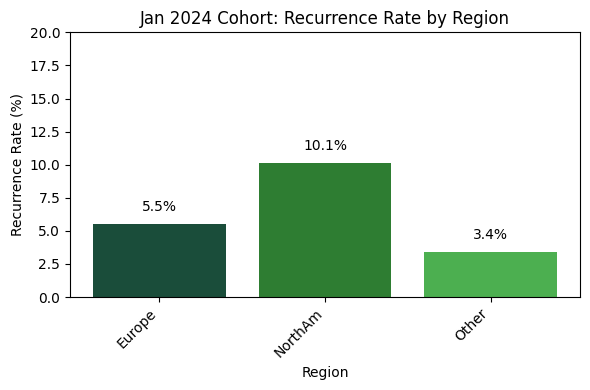

Recurring rate by Platform:


,platform,cohort_size,recur_users,recur_rate
0,Android,6720,335,5.0%
1,Web,5402,255,4.7%
2,iOS,5205,422,8.1%


Saved chart to ../exports/visualizations/recurrence_rate_jan2024_by_platform.png


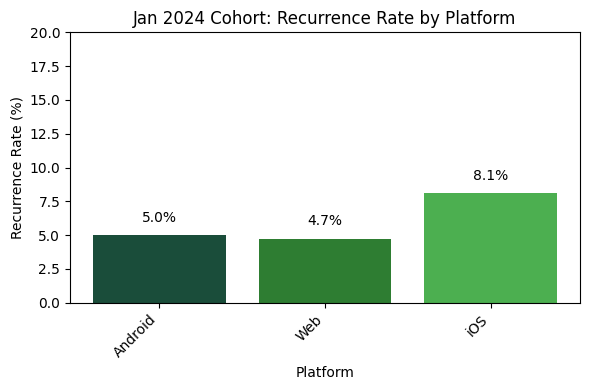

Recurring rate by Experience:


,experience,cohort_size,recur_users,recur_rate
0,Existing,7229,614,8.5%
1,New,10098,398,3.9%


Saved chart to ../exports/visualizations/recurrence_rate_jan2024_by_experience.png


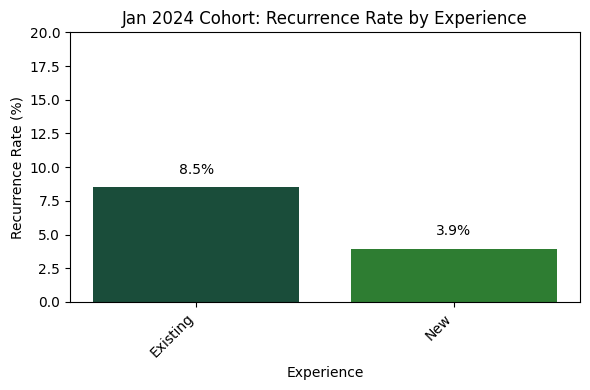

In [134]:
# 1) Determine each user’s first transfer month (cohort)
first_transfer = (
    transfers
    .sort_values("created_dt")
    .groupby("user_id")["created_dt"]
    .first()
    .dt.to_period("M")
    .dt.to_timestamp()
    .rename("first_month")
)
users = first_transfer.reset_index()

# 2) Filter to January 2024 cohort
cohort_month = pd.Timestamp("2024-01-01")
jan_cohort = users[users["first_month"] == cohort_month].copy()

# 3) Count funded transfers per user
funded_counts = (
    transfers[transfers["transfer_funded"]]
    .groupby("user_id")["transfer_id"]
    .count()
    .rename("funded_tx_count")
)
jan_cohort = jan_cohort.merge(
    funded_counts, on="user_id", how="left"
).fillna({"funded_tx_count": 0})

# 4) Flag recurring within cohort (>= 2 funded transfers)
jan_cohort["is_recur"] = jan_cohort["funded_tx_count"] >= 2

# 5) Bring in segment metadata
meta = transfers.drop_duplicates("user_id")[["user_id","region","platform","experience"]]
jan_cohort = jan_cohort.merge(meta, on="user_id", how="left")

# 6) Compute and print overall recurrence rate
overall_rate = jan_cohort["is_recur"].mean()
print(f"Jan 2024 cohort recurring rate (>=2 funded transfers): {overall_rate:.1%}\n")

# 7) Recurrence rate by segment with bar charts
dims = ["region", "platform", "experience"]

for dim in dims:
    agg = (
        jan_cohort
        .groupby(dim)
        .agg(
            cohort_size = ("user_id", "count"),
            recur_users = ("is_recur", "sum")
        )
        .assign(recur_rate = lambda df: df["recur_users"] / df["cohort_size"])
        .reset_index()
    )
    print(f"Recurring rate by {dim.capitalize()}:")
    display(agg.style.format({"recur_rate": "{:.1%}"}))
    
    # Plot bar chart
    plt.figure(figsize=(6,4))
    colors = [WISE_COLORS[i % len(WISE_COLORS)] for i in range(len(agg))]
    plt.bar(agg[dim], agg["recur_rate"] * 100, color=colors)
    plt.title(f"Jan 2024 Cohort: Recurrence Rate by {dim.capitalize()}")
    plt.xlabel(dim.capitalize())
    plt.ylabel("Recurrence Rate (%)")
    plt.ylim(0,20)
    plt.xticks(rotation=45, ha="right")
    for i, rate in enumerate(agg["recur_rate"]):
        plt.text(i, rate*100 + 1, f"{rate:.1%}", ha="center")
    plt.tight_layout()
    filename = "../exports/visualizations/recurrence_rate_jan2024_by_{}.png".format(dim)
    plt.savefig(filename, dpi=180)

    print("Saved chart to", filename)
    plt.show()


In [139]:
jan_cohort

,user_id,first_month,funded_tx_count,is_recur,region,platform,experience
0,1000006.0,2024-01-01,0.0,False,Other,Web,New
1,1000020.0,2024-01-01,1.0,False,Europe,iOS,Existing
2,1000093.0,2024-01-01,1.0,False,Other,Android,New
3,1000144.0,2024-01-01,1.0,False,Other,iOS,New
4,1000174.0,2024-01-01,0.0,False,NorthAm,Web,New
...,...,...,...,...,...,...,...
17322,1999728.0,2024-01-01,0.0,False,Other,iOS,New
17323,1999735.0,2024-01-01,0.0,False,NorthAm,iOS,New
17324,1999805.0,2024-01-01,0.0,False,Other,Web,Existing
17325,1999975.0,2024-01-01,0.0,False,Other,Web,New


Saved chart to ../exports/visualizations/recurrence_rate_jan2024_NorthAm_By_XP.png


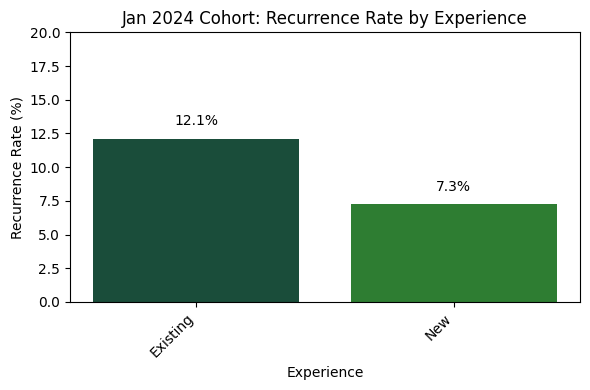

In [142]:
    agg = (
        jan_cohort[jan_cohort.region == "NorthAm"]
        .groupby("experience")
        .agg(
            cohort_size = ("user_id", "count"),
            recur_users = ("is_recur", "sum")
        )
        .assign(recur_rate = lambda df: df["recur_users"] / df["cohort_size"])
        .reset_index()
    )

    # Plot bar chart
    plt.figure(figsize=(6,4))
    colors = [WISE_COLORS[i % len(WISE_COLORS)] for i in range(len(agg))]
    plt.bar(agg[dim], agg["recur_rate"] * 100, color=colors)
    plt.title(f"Jan 2024 Cohort: Recurrence Rate by {dim.capitalize()}")
    plt.xlabel(dim.capitalize())
    plt.ylabel("Recurrence Rate (%)")
    plt.ylim(0,20)
    plt.xticks(rotation=45, ha="right")
    for i, rate in enumerate(agg["recur_rate"]):
        plt.text(i, rate*100 + 1, f"{rate:.1%}", ha="center")
    plt.tight_layout()
    filename = "../exports/visualizations/recurrence_rate_jan2024_NorthAm_By_XP.png".format(dim)
    plt.savefig(filename, dpi=180)

    print("Saved chart to", filename)
    plt.show()

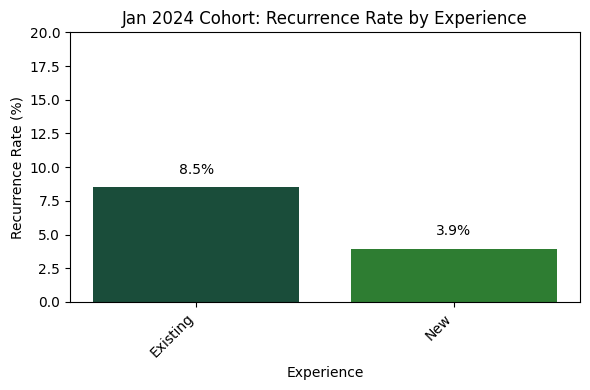

In [128]:
    # Plot bar chart
    plt.figure(figsize=(6,4))
    colors = [WISE_COLORS[i % len(WISE_COLORS)] for i in range(len(agg))]
    plt.bar(agg[dim], agg["recur_rate"] * 100, color=colors)
    plt.title(f"Jan 2024 Cohort: Recurrence Rate by {dim.capitalize()}")
    plt.xlabel(dim.capitalize())
    plt.ylabel("Recurrence Rate (%)")
    plt.ylim(0,20)
    plt.xticks(rotation=45, ha="right")
    for i, rate in enumerate(agg["recur_rate"]):
        plt.text(i, rate*100 + 1, f"{rate:.1%}", ha="center")
    plt.tight_layout()
    plt.show()

In [ ]:
#Breaking donw by two dimensions



Days between funded transfers (Jan cohort):
count    1042.0
mean       26.0
std        11.9
min         1.0
25%        18.0
50%        26.0
75%        35.0
max        57.0
Name: delta_days, dtype: object


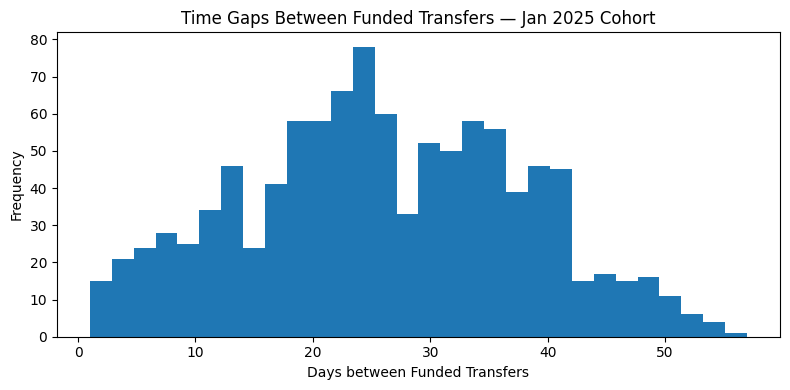


Median gap (days) by platform:
platform
Web        25.0
iOS        25.0
Android    27.0
Name: delta_days, dtype: object


In [124]:
funded = transfers[transfers["transfer_funded"]].copy()
jan_cohort_ids = jan_cohort['user_id'].nunique()

funded = (
    transfers[
        transfers["transfer_funded"] & 
        transfers["user_id"].isin(jan_cohort_ids)
    ]
    .sort_values(["user_id","funded_dt"])
)

# 5) Compute time to previous funded transfer per user
funded["prev_funded_dt"] = (
    funded
    .groupby("user_id")["funded_dt"]
    .shift(1)
)
funded = funded.dropna(subset=["prev_funded_dt"])

# 6) Calculate interval in days
funded["delta_days"] = (
    (funded["funded_dt"] - funded["prev_funded_dt"])
    .dt.total_seconds() / 86400
)

# 7) Summary statistics for January cohort
print("Days between funded transfers (Jan cohort):")
print(funded["delta_days"].describe().apply(lambda x: f"{x:.1f}"))

# 8) Histogram of intervals
plt.figure(figsize=(8,4))
plt.hist(funded["delta_days"], bins=30)
plt.xlabel("Days between Funded Transfers")
plt.ylabel("Frequency")
plt.title("Time Gaps Between Funded Transfers — Jan 2025 Cohort")
plt.tight_layout()
plt.show()

# 9) (Optional) Median gap by platform
med_platform = (
    funded
    .groupby("platform")["delta_days"]
    .median()
    .sort_values()
)
print("\nMedian gap (days) by platform:")
print(med_platform.apply(lambda x: f"{x:.1f}"))

## New User Analysis 

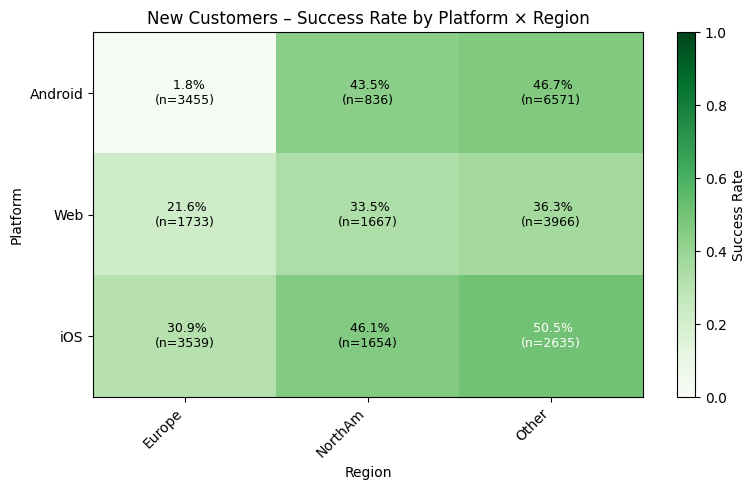

In [136]:
# 1) Filter to New customers
new_cust = transfers[transfers["experience"] == "New"].copy()
new_cust["success_event"] = (new_cust["status"] != "unsettled").astype(int)

# 2) Build success‐rate pivot (Platform × Region)
pivot_sr = (
    new_cust
    .groupby(["platform", "region"], dropna=False)
    .agg(success_rate=("success_event", "mean"))
    .reset_index()
    .pivot(index="platform", columns="region", values="success_rate")
)

# 3) Build counts pivot for annotation
pivot_n = (
    new_cust
    .groupby(["platform", "region"], dropna=False)
    .size()
    .unstack(fill_value=0)
)

# 4) Plot heatmap
fig, ax = plt.subplots(figsize=(8,5))
cax = ax.imshow(pivot_sr, aspect="auto", cmap="Greens", vmin=0, vmax=1)
fig.colorbar(cax, label="Success Rate")

# Tick labels
ax.set_xticks(np.arange(len(pivot_sr.columns)))
ax.set_yticks(np.arange(len(pivot_sr.index)))
ax.set_xticklabels(pivot_sr.columns, rotation=45, ha="right")
ax.set_yticklabels(pivot_sr.index)

# Annotate each cell
for i, plat in enumerate(pivot_sr.index):
    for j, reg in enumerate(pivot_sr.columns):
        sr = pivot_sr.loc[plat, reg]
        n  = pivot_n.loc[plat, reg]
        text = f"{sr*100:>5.1f}%\n(n={n})"
        ax.text(j, i, text,
                ha="center", va="center",
                color="white" if sr > 0.5 else "black",
                fontsize=9)

ax.set_title("New Customers – Success Rate by Platform × Region")
ax.set_xlabel("Region")
ax.set_ylabel("Platform")
plt.tight_layout()
plt.show()

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/2075313820.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  (transfers["created_dt"].dt.to_period("M").dt.to_timestamp() == month_ts)


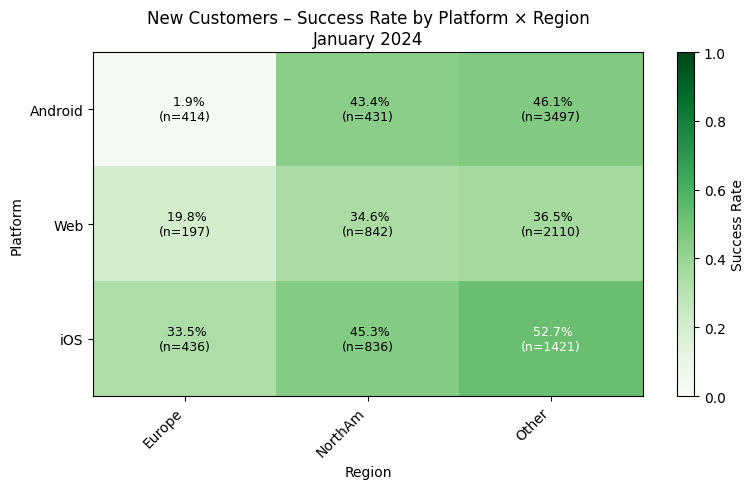

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1891/2075313820.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  (transfers["created_dt"].dt.to_period("M").dt.to_timestamp() == month_ts)


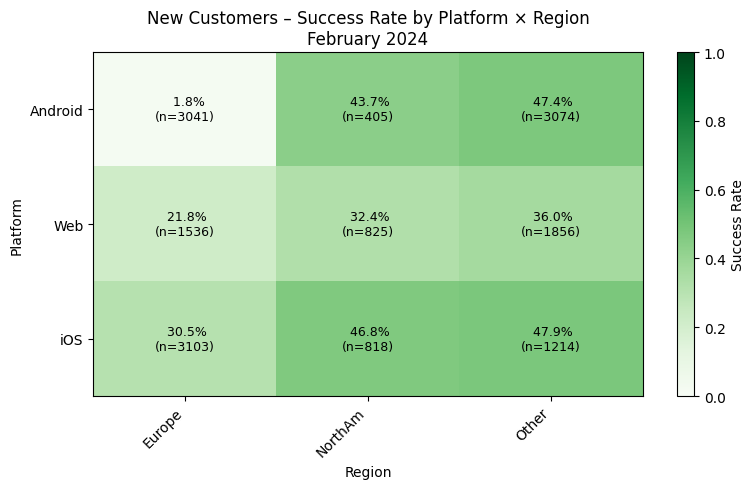

In [137]:
def plot_month_heatmap(month_label, month_ts):
    # Filter new customers with transfer_created in the given month
    df = transfers[
        (transfers["experience"] == "New") &
        (transfers["created_dt"].dt.to_period("M").dt.to_timestamp() == month_ts)
    ].copy()
    df["success_event"] = (df["status"] != "unsettled").astype(int)

    # Pivot success rate: Platform × Region
    pivot_sr = (
        df.groupby(["platform","region"], dropna=False)
          .agg(success_rate=("success_event","mean"))
          .reset_index()
          .pivot(index="platform", columns="region", values="success_rate")
    )

    # Pivot counts for annotation
    pivot_n = (
        df.groupby(["platform","region"], dropna=False)
          .size()
          .unstack(fill_value=0)
    )

    # Plot
    fig, ax = plt.subplots(figsize=(8,5))
    cax = ax.imshow(pivot_sr, aspect="auto", cmap="Greens", vmin=0, vmax=1)
    fig.colorbar(cax, label="Success Rate")

    ax.set_xticks(np.arange(len(pivot_sr.columns)))
    ax.set_yticks(np.arange(len(pivot_sr.index)))
    ax.set_xticklabels(pivot_sr.columns, rotation=45, ha="right")
    ax.set_yticklabels(pivot_sr.index)

    for i, plat in enumerate(pivot_sr.index):
        for j, reg in enumerate(pivot_sr.columns):
            sr = pivot_sr.loc[plat, reg]
            n  = pivot_n.loc[plat, reg]
            txt = f"{sr*100:>5.1f}%\n(n={n})"
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if sr>0.5 else "black",
                    fontsize=9)

    ax.set_title(f"New Customers – Success Rate by Platform × Region\n{month_label}")
    ax.set_xlabel("Region")
    ax.set_ylabel("Platform")
    plt.tight_layout()
    plt.show()

# Plot for January and February 2024
plot_month_heatmap("January 2024", pd.Timestamp("2024-01-01"))
plot_month_heatmap("February 2024", pd.Timestamp("2024-02-01"))